# Response to Reviewer 1: similarity of the two MDS solutions

Reviewer 1 asked to quantify the similarity of the two MDS solutions found with the task data and the movie data.

We will do the following:

1. Given the distances between pairs of ROIs, used to compute the MDS solution, we will correlate the ranks of their upper-triangular matrix (Spearman correlation). We will then bootstrap the task data, maintaining the movie data fixed since it has been already cross-validated across subjects, to obtain 95% confidence intervals of the correlation.

2. Perform procrustes alignment of the movie-data MDS solution in 3 dimensions to the task-data MDS solution, and then plot the change between the two.

[Skip to the analyses](#Load-data)

## Import and define functions

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('dark')

import sys
p = ['../']
for pp in p:
    if pp not in sys.path:
        sys.path.insert(1, pp)

import expdir
from mvpa2.suite import *
from mds_rois import xboost
fns = expdir.expdir()
from scipy.spatial import distance as dist
import seaborn as sns
from os.path import join as pjoin
import pandas as pd
from scipy.spatial.distance import cdist

In [2]:
img_dir = './img_response_reviewers'
try:
    os.makedirs(img_dir)
except OSError:
    pass

In [3]:
def load_dsm(subnr):
    fn = pjoin(fns.mvpadir(subnr), 'roi_rsa_jimroi_5r_fisher_nooverlap/dsm_condition.hdf5')
    ds = h5load(fn)
    return ds

In [4]:
def make_ds_distance(ds, make_symmetric=False, rank=False):
    if rank:
        ds_ = np.apply_along_axis(rankdata, 1, ds)
    else:
        ds_ = ds.samples
    if make_symmetric:
        # add transpose and take only upper triangular with diagonal
        ds_new = []
        for row in ds_:
            tmp = row.reshape(8, 8)
            tmp += tmp.T
            tmp /= 2
            ds_new.append(tmp[np.triu_indices_from(tmp)])
        ds_ = np.array(ds_new)
        
    ds_dist = squareform(pdist(ds_, metric='correlation'))
    return Dataset(ds_dist, sa=ds.sa, fa={'roi': ds.sa.targets})

In [5]:
def get_average_distance_ds(roi_rdm):
    """Generate a group distance matrix dataset"""
    dsms_avg = np.mean([pdist(ds, 'correlation') for ds in roi_rdm], axis=0)
    dsms_avg = squareform(dsms_avg)
    dsms_avg = Dataset(dsms_avg,
                       sa=roi_rdm[0].sa,
                       fa={'roi': roi_rdm[0].sa.targets})
    return dsms_avg

In [6]:
def reorder_dataset(ds, labels_ord):
    labels_orig = ds.sa.targets
    ds_ord = ds.copy()
    idx_reorder = [np.where(lbl == labels_orig)[0][0] for lbl in labels_ord]

    ds_ord = ds_ord[:, idx_reorder][idx_reorder, :]
    return ds_ord

In [7]:
def get_labels_color(labels):
    #assign different colors depending on system
    # using colorbrewer2.org qualitative 6-class palette
    early_visual = '#0000FF'
    dorsal_core_system = '#b1551c'#'#e4761a'
    ventral_core_system = '#e41a1a'
    anterior_core_system = '#e4a11a'#'#4daf4a'
    theory_of_mind = '#008100'
    precuneus = '#099997'

    label2color = {
    'EV1 - L': early_visual,
    'EV1 - R': early_visual,
    'EV2 - L': early_visual,
    'EV2 - R': early_visual,
    'IFG1 - L': anterior_core_system,
    'IFG2 - L': anterior_core_system,
    'IFG2 - R': anterior_core_system,
    'MPFC - L': theory_of_mind,
    'MPFC - R': theory_of_mind,
    'OccFus - L': ventral_core_system,
    'OccFus - R': ventral_core_system,
    'TPJ - L': theory_of_mind,
    'TPJ - R': theory_of_mind,
    'aFus - R': ventral_core_system,
    'aMTG - L': dorsal_core_system,
    'aMTG - R': dorsal_core_system,
    'dPreCun - L': precuneus,
    'dPreCun - R': precuneus,
    'mFus - L': ventral_core_system,
    'mFus - R': ventral_core_system,
    'mMTG - L': dorsal_core_system,
    'mMTG - R': dorsal_core_system,
    'mPreCun - L': precuneus,
    'mPreCun - R': precuneus,
    'pFus - L': ventral_core_system,
    'pFus - R': ventral_core_system,
    'pMTG - L': dorsal_core_system,
    'pMTG - R': dorsal_core_system,
    'vPreCun - L': precuneus,
    'vPreCun - R': precuneus,
    }

    labels_color = [label2color[lbl] for lbl in labels]
    assert(len(labels) == len(labels_color))
    return labels_color

In [8]:
def plot_mds_together(coordinates1, coordinates2, labels, labels_color=None):
    """Plot the two MDS together with lines going from coordinates2 to coordinates2"""
    fig = plt.figure(figsize=(16, 12))
    nd = coordinates1.shape[1]
    ax = fig.add_subplot(111)

    # I should receive a set of coordinates, a set of labels, and an adjacency matrix
    assert(len(coordinates1) == len(labels))
    assert(len(coordinates2) == len(labels))
    ax.scatter(coordinates1[:, 0], coordinates1[:, 1], s=1, c='k')
    ax.scatter(coordinates2[:, 0], coordinates2[:, 1], s=1, c='k')

    
    # Add lines between the two points
    common_kwargs = dict(
        alpha=0.7,
        #color=m.to_rgba(value),
        #alpha=norm_alpha(value),
        #linewidth=norm_size(value)#value*linewidth_mult
        #linewidth=4
    )
    for (xs, ys), (xe, ye), color in zip(coordinates2, coordinates1, labels_color):
        #ax.plot([xs, xe], [ys, ye], color=color, **common_kwargs)
        ax.arrow(xs, ys, xe - xs, ye - ys, color=color, 
                 width=0.0002, **common_kwargs)


    # Add the labels only for the first dataset
    text_kwargs = dict(fontsize=16,
                    horizontalalignment='center',
                    verticalalignment='center',
                    weight='bold')
    
    if labels_color is None:
        labels_color = ['black'] * len(labels)

    for ((x, y), label, color) in zip(coordinates2, labels, labels_color):
        ax.text(x, y, label, color='white', #color, 
                bbox=dict(facecolor=color, alpha=0.6, boxstyle="round,pad=0.3"), **text_kwargs)

        
    #pretty_plot(ax)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
    return fig#, ax

## Load data

### Task data

In [9]:
# this contains the first level RDMs
roi_rdm = [load_dsm(i) for i in range(1, 34)]
# this contains the second level RDMs (between ROIs) for each subject
roi_dist = [make_ds_distance(ds, make_symmetric=True) for ds in roi_rdm]

In [10]:
roi_dist[0]

<Dataset: 30x30@float64, <sa: centers,targets>, <fa: roi>>

### Movie data

In [11]:
res_hpal1 = h5load('roi_rdm_hpal_part1.hdf5')
res_hpal2 = h5load('roi_rdm_hpal_part2.hdf5')

In [12]:
# average across parts
hpal_distance = np.tanh((np.arctanh(res_hpal1) + np.arctanh(res_hpal2))/2)
# normalize by noise values, as in Guntupalli et al., 2016
diag = np.diag(hpal_distance).reshape((1, -1))
sqrt_diag = np.sqrt((diag * diag.T))
# normalize by noise and make distance
hpal_distance_norm = 1. - hpal_distance / sqrt_diag

In [13]:
# get the right order of labels for the movie data
roi_coord = pd.read_csv('new_roi_jim.csv')
labels_hpal = list(roi_coord['Abbreviation'])

In [14]:
# make it a ds so we can reorder it
hpal_distance_norm_ds = Dataset(hpal_distance_norm.copy())
hpal_distance_norm_ds.sa['targets'] = labels_hpal

## 1. Compute similarity

First we reorder all datasets in the same way, so we have correspondence between task and movie data

In [15]:
task_dist_ord = map(lambda x: reorder_dataset(x, labels_hpal), roi_dist)
hpal_dist_ord = hpal_distance_norm_ds

In [16]:
for task_dist in task_dist_ord:
    assert(np.array_equal(task_dist.targets, hpal_dist_ord.targets))

The matrix is symmetric, so we'll take only the upper triangular matrix

In [17]:
hpal_dist_ord_triu = squareform(hpal_dist_ord.samples)
task_dist_ord_triu = np.array(map(lambda x: squareform(x.samples), task_dist_ord))

Compute the correlation $\rho_0$

In [18]:
from scipy.stats import spearmanr

In [19]:
def correlate(x, y):
    return spearmanr(x, y)[0]

In [20]:
r0 = correlate(
    hpal_dist_ord_triu,
    task_dist_ord_triu.mean(axis=0))

In [21]:
# Now we can bootstrap
nbs = 10000
corr_bs = []
# set seed for reproducibility
np.random.seed(345)
for idx in xboost(task_dist_ord_triu.shape[0], nbs):
    this_bs = task_dist_ord_triu[idx].mean(axis=0)
    corr_bs.append(correlate(this_bs, hpal_dist_ord_triu))
corr_bs = np.array(corr_bs)

In [22]:
cis = np.percentile(corr_bs, [2.5, 97.5])

In [23]:
print("Correlation between Movie and Task: {0} [{1}, {2}]".format(
    np.round(r0, 2), *np.round(cis, 2)))

Correlation between Movie and Task: 0.48 [0.34, 0.49]


Plot a scatterplot

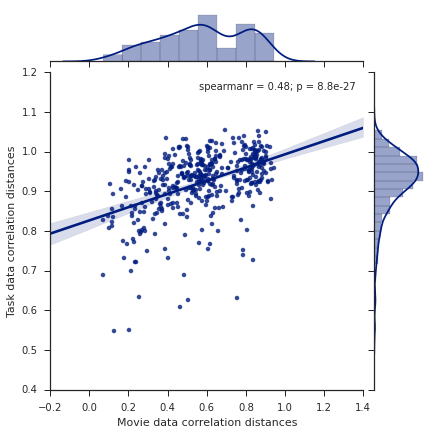

In [29]:
ax = sns.jointplot(hpal_dist_ord_triu[None, :], 
              task_dist_ord_triu.mean(axis=0)[None, :], 
              kind='reg', stat_func=spearmanr)
ax.set_axis_labels(xlabel='Movie data correlation distances', ylabel='Task data correlation distances');
ax.savefig(pjoin(img_dir, 'scatterplot_mds.png'), dpi=300)

## 2. Perform Procrustes alignment to plot one MDS solution onto the other

In [24]:
from mds_rois import mdsf
from scipy.spatial import procrustes

In [25]:
# task solution
task_coordinate = mdsf(squareform(task_dist_ord_triu.mean(axis=0)), k=3)
# movie solution
movie_coordinate = mdsf(squareform(hpal_dist_ord_triu), k=3)

In [26]:
task_pr, movie_pr, disparity = procrustes(task_coordinate, movie_coordinate)

In [27]:
labels_color = get_labels_color(labels_hpal)

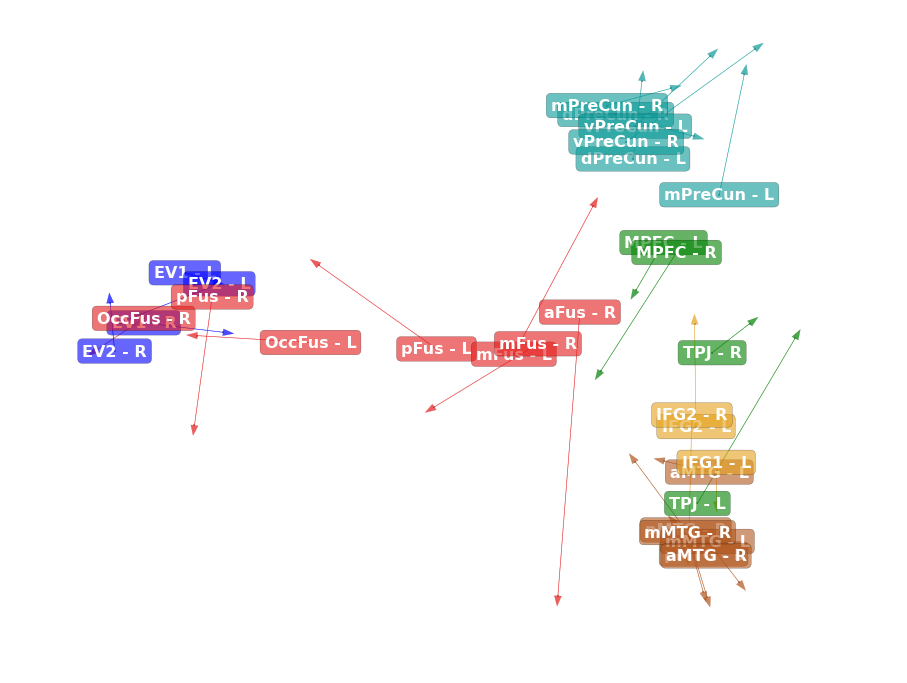

In [28]:
fig = plot_mds_together(task_pr[:, [0, 1]], movie_pr[:, [0, 1]], 
                        labels=labels_hpal, labels_color=labels_color);
sns.despine(left=True, bottom=True)
fig.savefig(pjoin(img_dir, 'mds_movie2task.png'), dpi=300)